In [1]:
import os
import sys
sys.path.append('lib')
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import sklearn.preprocessing
import pandas as pd

import utils
from RNN import RNN
from covid_data import covid_data

# Pre-training

## Set hyper parameters

In [2]:
#* Name of data file (last date of available data)
LAST_DAY='2021-05-24'

#* Recurrent Neural Network Type: Choosed between LSTM, GRU
RNN_TYPE = "biLSTM"

#* prefix of model name: Full information of model
PREFIX = '_'.join([LAST_DAY, RNN_TYPE]) + "_"

#* Set default precision
PRECISION = '32'
torch.set_default_dtype(getattr(torch, 'float' + PRECISION))
if PRECISION != '32':
    PREFIX += "_{}".format(PRECISION)

#* Take bi-directional
if "bi" in RNN_TYPE:
    RNN_TYPE = RNN_TYPE[2:]
    BIDIRECTIONAL = True
else:
    BIDIRECTIONAL = False

#* Features to use: Choose between 'Open', 'Close', 'High', 'Low'
IN_FEATURES = ['confirmed', 'death', 'released', 'negative', 'tested', 'stringency_index']
OUT_FEATURES = ['confirmed']
if len(IN_FEATURES) == 6:
    PREFIX += 'all2' + ''.join([feature[0] for feature in OUT_FEATURES])
else:
    PREFIX += ''.join([feature[0] for feature in IN_FEATURES]) + '2' + ''.join([feature[0] for feature in OUT_FEATURES])

#* Number of days to use prediction
PAST_DAYS = 60
if PAST_DAYS != 60:
    PREFIX += "_PD{}".format(PAST_DAYS)

#* Number of days to predict
SUCCESSIVE_DAYS = 5
if SUCCESSIVE_DAYS > 1:
    PREFIX += "_SD{}".format(SUCCESSIVE_DAYS)

#* Number of days to use prediction
PAST_DAYS = 60
if PAST_DAYS != 60:
    PREFIX += "_PD{}".format(PAST_DAYS)

#* Scaler
SCALER_NAME = 'MinMaxScaler'
if SCALER_NAME != 'MinMaxScaler':
    PREFIX += "_SC{}".format(SCALER_NAME)

#* Hidden size of LSTM/GRU
HIDDEN_SIZE = 100
if HIDDEN_SIZE != 50:
    PREFIX += "_HS{}".format(HIDDEN_SIZE)

#* Number of stacked layers of LSTM/GRU
NUM_LAYERS = 10
if NUM_LAYERS != 4:
    PREFIX += "_NL{}".format(NUM_LAYERS)

#* Drop out
DROPOUT = 0.4
if DROPOUT:
    PREFIX += "_DO{:.2f}".format(DROPOUT)

#* Optimizer name
OPTIMIZER_NAME = 'RMSprop'
if OPTIMIZER_NAME != 'RMSprop':
    PREFIX += '_OP' + OPTIMIZER_NAME

#* Learning rate for optimizer
LEARNING_RATE = 1e-4
if LEARNING_RATE:
    PREFIX += "_LR{}".format(LEARNING_RATE)

#* Regularization for optimizer
L2_REGULARIZATION = 5e-4
if L2_REGULARIZATION:
    PREFIX += "_RG{}".format(L2_REGULARIZATION)

#* Loss function
LOSS_NAME = 'MSELoss'
if LOSS_NAME != 'MSELoss':
    PREFIX += "_LF{}".format(LOSS_NAME)

#* Early stopping patience
PATIENCE = 10

print("prefix:", PREFIX)

#* Check device
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEVICE

prefix: 2021-05-24_biLSTM_cdrnts2c_SD5_HS100_NL10_DO0.40_LR0.0001_RG0.0005


device(type='cuda', index=0)

## Generate dataset

In [3]:
data = covid_data(last_day=LAST_DAY,
                  in_features=IN_FEATURES,
                  out_features=OUT_FEATURES,
                  precision=PRECISION,
                  past_days=PAST_DAYS,
                  successive_days=SUCCESSIVE_DAYS,
                  scaler_name=SCALER_NAME)

train_loader = data.get_train_loader(batch_size=64, num_workers=4)
val_loader = data.get_val_loader(batch_size=64)

Finished reading a file 2021-05-24
-----------------------------
Number of train set: 342 with input: (60, 6) output: (5, 1)
Number of validation set: 80 with input: (60, 6) output: (5, 1)


## Define neural network, loss function, optimizer type

In [4]:
#* Define model
model = RNN(rnn_type=RNN_TYPE,
            in_features=IN_FEATURES,
            out_features=OUT_FEATURES,
            successive_days=SUCCESSIVE_DAYS,
            hidden_size=HIDDEN_SIZE,
            bidirectional=BIDIRECTIONAL,
            dropout=DROPOUT).to(DEVICE)

#* Initialize epoch, loss, optimizer, loss function
epoch, min_val_loss = 0, np.Inf
train_loss_list, val_loss_list = np.array([]), np.array([])
optimizer = getattr(optim, OPTIMIZER_NAME)(params=model.parameters(),
                                           lr=LEARNING_RATE,
                                           weight_decay=L2_REGULARIZATION)
loss_func = getattr(nn, LOSS_NAME)(reduction='sum')

#* Summarize the model
example_input, example_output = data.train_dataset[0]
utils.model_summary(model, input_size=example_input.shape, precision=PRECISION)

Layer (type:depth-idx)                   Input Shape      Output Shape     Kernel Shape     Param #          Mult-Adds
RNN                                      --               --               --               --               --
├─rnn.weight_ih_l0                                                         [400, 6]
├─rnn.weight_hh_l0                                                         [400, 100]
├─rnn.weight_ih_l0_reverse                                                 [400, 6]
├─rnn.weight_hh_l0_reverse                                                 [400, 100]
├─rnn.weight_ih_l1                                                         [400, 200]
├─rnn.weight_hh_l1                                                         [400, 100]
├─rnn.weight_ih_l1_reverse                                                 [400, 200]
├─rnn.weight_hh_l1_reverse                                                 [400, 100]
├─rnn.weight_ih_l2                                                         [400, 200]

## Load model if needed

In [10]:
#* Load model
epoch = 22

checkpoint = torch.load(os.path.join('model', PREFIX + '_{}.pth'.format(epoch)), map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
loss_func = checkpoint['loss']
train_loss_list = checkpoint['train_loss_list']
val_loss_list = checkpoint['val_loss_list']
min_val_loss = val_loss_list[-1]
test_loss = checkpoint['test_loss']
print("Loaded model has average test loss: {:.6f}, recurrent test loss: {:.6f}".format(test_loss[0], test_loss[1]))

try:
    print("REMARK:", checkpoint['Remark'])
except KeyError:
    pass


# Training

In [5]:
new_train_loss_list, new_val_loss_list, best = utils.train(model,
                                                           max_epoch=100,
                                                           loss_func=loss_func,
                                                           optimizer=optimizer,
                                                           train_loader=train_loader,
                                                           val_loader=val_loader,
                                                           early_stop_counter=PATIENCE,
                                                           min_val_loss=min_val_loss,
                                                           verbose=1)

#* Load best model state and epoch number
best_epoch = best[1]
if best[0] is None:     # Only when loaded model and newly trained is already overfitted
    model.load_state_dict(checkpoint['model_state_dict'])
else:
    model.load_state_dict(best[0])

#* Update epoch and loss lists, accuracy lists
epoch += best_epoch + 1
train_loss_list = np.concatenate((train_loss_list,
                                  new_train_loss_list[:best_epoch + 1 + PATIENCE]))
val_loss_list = np.concatenate((val_loss_list,
                                new_val_loss_list[:best_epoch + 1 + PATIENCE]))


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1	Validation loss decreased (inf --> 0.417277). Saving model
Epoch 2	Validation loss decreased (0.417277 --> 0.221682). Saving model
Epoch 3	Validation loss decreased (0.221682 --> 0.131587). Saving model
Epoch 4	Early Stopping counter: 1/10
Epoch 5	Early Stopping counter: 2/10
Epoch 6	Validation loss decreased (0.131587 --> 0.096860). Saving model
Epoch 7	Validation loss decreased (0.096860 --> 0.076732). Saving model
Epoch 8	Early Stopping counter: 1/10
Epoch 9	Early Stopping counter: 2/10
Epoch 10	Validation loss decreased (0.076732 --> 0.070627). Saving model
Epoch 11	Early Stopping counter: 1/10
Epoch 12	Validation loss decreased (0.070627 --> 0.067267). Saving model
Epoch 13	Early Stopping counter: 1/10
Epoch 14	Early Stopping counter: 2/10
Epoch 15	Early Stopping counter: 3/10
Epoch 16	Early Stopping counter: 4/10
Epoch 17	Early Stopping counter: 5/10
Epoch 18	Early Stopping counter: 6/10
Epoch 19	Early Stopping counter: 7/10
Epoch 20	Early Stopping counter: 8/10
Epoch 21	

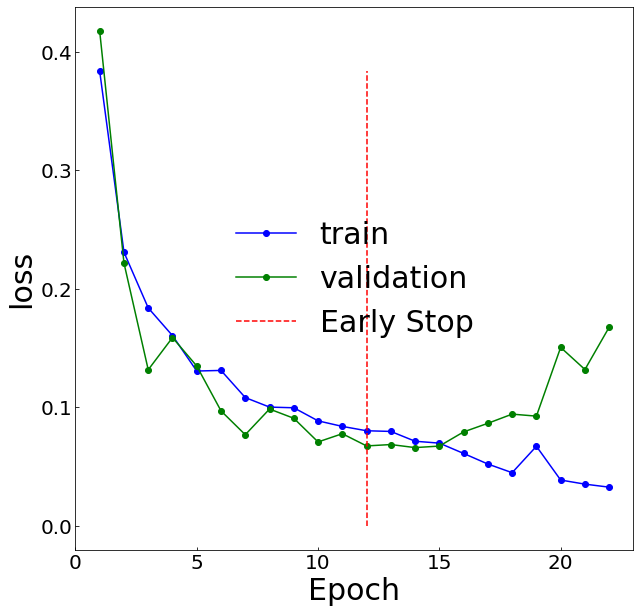

In [9]:
ax = utils.plot_loss(train_loss_list, val_loss_list, epoch)

# _ = ax.set_ylim([0, 0.2])



# Training

Average test finished with 0.61 seconds
Loss: 0.167548
Recurrent test finished with 0.66 seconds
Loss: 0.039735


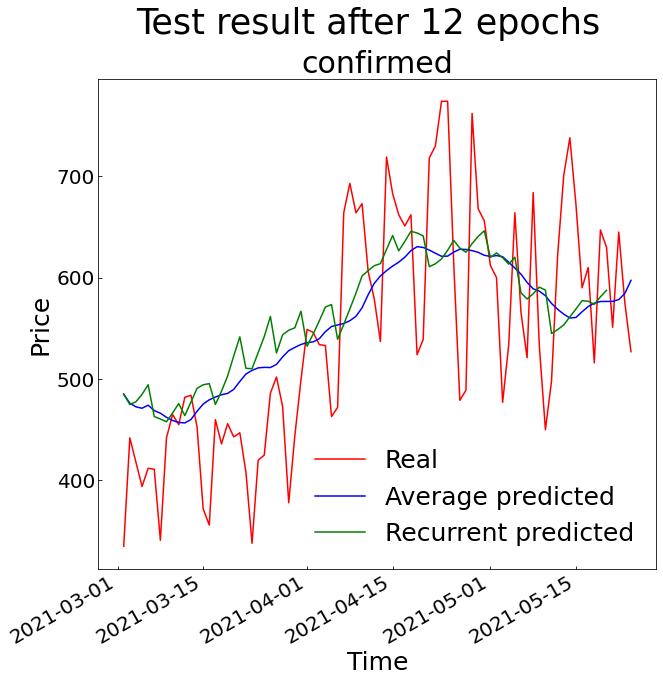

In [10]:
avg_prediction, avg_test_loss = utils.average_test(model, data,
                                                   loss_func=loss_func,
                                                   verbose=True)
recurrent_prediction, recurrent_test_loss = utils.recurrent_test(model, data,
                                                                 loss_func=loss_func,
                                                                 verbose=True)

ax = utils.plot_prediction(data=data,
                           epoch=epoch,
                           #   save_path=os.path.join('fig', PREFIX + "_prediction.png"),
                           avg_prediction=avg_prediction,
                           recurrent_prediction=recurrent_prediction)


# Predict

In [22]:
last_input = data.val_raw[-PAST_DAYS:, data.in_features_idx]
last_input = torch.as_tensor(last_input).unsqueeze(0).to(DEVICE)

model.eval()
with torch.no_grad():
    prediction = model(last_input)
prediction = data.val_output_scaler.inverse_transform(prediction.squeeze(0).cpu().numpy())

print(prediction)


[[545.0335 ]
 [546.75726]
 [548.3268 ]
 [552.78394]
 [576.68726]]


# Save the model

In [12]:
#* Save the model with current state
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_func,
            'train_loss_list': train_loss_list[:epoch],
            'val_loss_list': val_loss_list[:epoch],
            'Remark': 'Early stopped',
            'test_loss': (avg_test_loss, recurrent_test_loss)},
           os.path.join('model', PREFIX + '_{}.pth'.format(epoch)))

print("Saved model", PREFIX + '_{}.pth'.format(epoch))

Saved model 2021-05-24_biLSTM_cdrnts2c_SD5_HS100_NL10_DO0.40_LR0.0001_RG0.0005_12.pth


# Find best model

In [14]:
best_loss = np.Inf
for file in os.listdir('model'):
    if "_SD{}".format(SUCCESSIVE_DAYS) in file:
        checkpoint = torch.load(os.path.join('model', file))
        test_loss = min(checkpoint['test_loss'][0], checkpoint['test_loss'][1])
        try:
            if test_loss < best_loss:
                best_name = file
                best_loss = test_loss
        except KeyError:
            print("Error: ", file)
print(best_name)
print("loss:", best_loss)

2021-05-24_biLSTM_cdrnts2c_SD5_HS100_NL10_DO0.40_LR0.0001_RG0.0005_12.pth
loss: 0.03973534862076385
